#Project on weather prediction with RNN (**Final Project**)
##  Artificial Neural Network and Deep Learning (CDSC 719)
#### Abraham Menberu GSR/4086/14
##### February 2023


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools
from datetime import datetime, date
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
#from prophet import Prophet
import tensorflow as tf
#from numba import cuda,vectorize,jit
sns.set()

In [3]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)
df = pd.read_csv(r'/content/drive/MyDrive/climate_2009_2016.csv')
df['Date Time'] = pd.to_datetime(df['Date Time'], format = "%d.%m.%Y %H:%M:%S" )
df = df.sort_values(by='Date Time')  # sort dataframe by date_time
df=df.drop_duplicates().reset_index(drop=True) # drop duplicates
df['diff'] = df['Date Time'].diff().dt.total_seconds() / 60  # Convert difference to minutes

ind = df.loc[df['diff']==4460].index.values[0]
df[ind-1:ind+2]
df['Date Time'] = pd.to_datetime(df['Date Time'], format = "%d.%m.%Y %H:%M:%S" )
df.set_index('Date Time', inplace=True)

dfr = df.resample('10Min') # resample data in 10Min to add the missing rows
dfr = dfr.interpolate('linear')
interp = pd.concat([df,dfr]).drop_duplicates(keep=False)
dfr['diff'] =  dfr.index.shift(1) - dfr.index
del dfr['diff']
dfrT=dfr['T (degC)'].resample('1D').mean().reset_index(drop=False)


In [6]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),diff
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,NaN
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,10.0
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,10.0
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,10.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0,10.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,10.0
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2,10.0


In [7]:
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),diff
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,NaN
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,10.0
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,10.0
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,10.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0,10.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,10.0
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2,10.0


In [8]:
features_columns =  ['p (mbar)','rho (g/m**3)','VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']
target_column = "T (degC)"

all_columns = features_columns + [target_column]
df = dfr[all_columns]
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(dfr[features_columns])
Y_data = Y_scaler.fit_transform(dfr[target_column].values.reshape(-1,1))

def custom_multi_variable(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
         end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)


In [9]:

hist_window = 10
horizon = 1
n_features = 6
train_size = int(0.75 * len(df))
test_size = len(df) - train_size

In [10]:
X_data

array([[0.81493857, 0.74321291, 0.00478157, 0.08167896, 0.74321291,
        0.07040328],
       [0.81542998, 0.74934898, 0.00456423, 0.07884288, 0.74934898,
        0.04921394],
       [0.81503686, 0.75066599, 0.00434688, 0.07827567, 0.75066599,
        0.01298701],
       ...,
       [0.84737101, 0.68526445, 0.03368833, 0.08791832, 0.68526445,
        0.07382092],
       [0.84727273, 0.70073932, 0.02738535, 0.08451503, 0.70073932,
        0.10184552],
       [0.84737101, 0.70918016, 0.02260378, 0.08564946, 0.70918016,
        0.08407382]])

In [11]:
lstm1_X_train, lstm1_y_train = custom_multi_variable(X_data, Y_data, 0, train_size, hist_window, horizon)

In [12]:
lstm1_X_test, lstm1_y_test = custom_multi_variable(X_data, Y_data, train_size, None, hist_window, horizon)


In [13]:
#Assigning the data to different Models to reduce the need to execute
# custom_multi_variable() everytime
SimpleRNN_X_train=lstm1_X_train
SimpleRNN_y_train=lstm1_y_train
SimpleRNN_X_test=lstm1_X_test
SimpleRNN_y_test=lstm1_y_test
GRU1_X_train=SimpleRNN_X_train
GRU1_y_train=SimpleRNN_y_train
GRU1_X_test=SimpleRNN_X_test
GRU1_y_test=SimpleRNN_y_test





In [14]:

# define model
SimpleRNN_model = Sequential()
SimpleRNN_model.add(tf.keras.layers.SimpleRNN(125, activation="tanh",return_sequences=True, input_shape=(hist_window, n_features)))
SimpleRNN_model.add(tf.keras.layers.SimpleRNN(125, activation="tanh",return_sequences=True))
SimpleRNN_model.add(Dense(1))
# Compiling the model
SimpleRNN_model.compile(optimizer="RMSprop", loss="mse")
SimpleRNN_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 10, 125)             │          16,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 10, 125)             │          31,375 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10, 1)               │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,001 (187.50 KB)

 Trainable params: 48,001 (187.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:

# define model
lstm1_model = Sequential()
lstm1_model.add(tf.keras.layers.LSTM(125, activation="tanh",return_sequences=True, input_shape=(hist_window, n_features)))
lstm1_model.add(tf.keras.layers.LSTM(125, activation="tanh",return_sequences=True))
lstm1_model.add(Dense(1))
# Compiling the model
lstm1_model.compile(optimizer="RMSprop", loss="mse")
lstm1_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 125)             │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 125)             │         125,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10, 1)               │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,626 (748.54 KB)

 Trainable params: 191,626 (748.54 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# define model
GRU1_model = Sequential()
GRU1_model.add(tf.keras.layers.GRU(125, activation="tanh",return_sequences=True, input_shape=(hist_window, n_features)))
GRU1_model.add(tf.keras.layers.GRU(125, activation="tanh",return_sequences=True))
GRU1_model.add(Dense(1))
# Compiling the model
GRU1_model.compile(optimizer="RMSprop", loss="mse")
GRU1_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 10, 125)             │          49,875 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 10, 125)             │          94,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10, 1)               │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,501 (564.46 KB)

 Trainable params: 144,501 (564.46 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,verbose=1)

if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    tf.config.list_physical_devices()
    # Fitting to the training set
    with tf.device('/device:GPU:0'):
        SimpleRNN_history =SimpleRNN_model.fit(SimpleRNN_X_train,SimpleRNN_y_train,epochs=10,validation_data=(SimpleRNN_X_test,SimpleRNN_y_test),batch_size=256,verbose=1,callbacks=[stop_early])
        lstm1_history =lstm1_model.fit(lstm1_X_train,lstm1_y_train,epochs=10,validation_data=(lstm1_X_test,lstm1_y_test),batch_size=256,verbose=1,callbacks=[stop_early])
        GRU1_history =GRU1_model.fit(GRU1_X_train,GRU1_y_train,epochs=10,validation_data=(GRU1_X_test,GRU1_y_test),batch_size=256,verbose=1,callbacks=[stop_early])
else:
    SimpleRNN_history =SimpleRNN_model.fit(SimpleRNN_X_train,SimpleRNN_y_train,epochs=10,validation_data=(SimpleRNN_X_test,SimpleRNN_y_test),batch_size=256,verbose=1,callbacks=[stop_early])
    lstm1_history =lstm1_model.fit(lstm1_X_train,lstm1_y_train,epochs=10,validation_data=(lstm1_X_test,lstm1_y_test),batch_size=256,verbose=1,callbacks=[stop_early])
    GRU1_history =GRU1_model.fit(GRU1_X_train,GRU1_y_train,epochs=10,validation_data=(GRU1_X_test,GRU1_y_test),batch_size=256,verbose=1,callbacks=[stop_early])


Epoch 1/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0434 - val_loss: 8.9134e-04
Epoch 2/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 6.9124e-04 - val_loss: 5.0859e-04
Epoch 3/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.2588e-04 - val_loss: 6.4843e-04
Epoch 4/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.7230e-04 - val_loss: 5.6806e-04
Epoch 5/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 4.3602e-04 - val_loss: 4.4695e-04
Epoch 6/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.1561e-04 - val_loss: 3.4120e-04
Epoch 7/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 3.9638e-04 - val_loss: 3.3408e-04
Epoch 8/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.9076e-04 - val_loss: 4.0372e-04
Epoch 9/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.8008e-04 - val_loss: 3.5422e-04
Epoch 10/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.7106e-04 - val_loss: 3.9566e-04
Epoch 1/10
1233/1233 ━━━━━━━━━━━━━━━━━━━

In [18]:
SimpleRNN_pred = SimpleRNN_model.predict(SimpleRNN_X_test,verbose=1)
lstm1_pred = lstm1_model.predict(lstm1_X_test,verbose=1)
GRU1_pred = GRU1_model.predict(GRU1_X_test,verbose=1)

3287/3287 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


In [19]:
SimpleRNN_y_pred = Y_scaler.inverse_transform(SimpleRNN_pred[:,-1])
SimpleRNN_y_test = Y_scaler.inverse_transform(SimpleRNN_y_test[:,-1])
SimpleRNN_y_pred2 = SimpleRNN_y_pred.reshape(-1,1)
SimpleRNN_y_test2 = SimpleRNN_y_test.reshape(-1,1)

lstm1_y_pred = Y_scaler.inverse_transform(lstm1_pred[:,-1])
lstm1_y_test = Y_scaler.inverse_transform(lstm1_y_test[:,-1])
lstm1_y_pred2 = lstm1_y_pred.reshape(-1,1)
lstm1_y_test2 = lstm1_y_test.reshape(-1,1)


GRU1_y_pred = Y_scaler.inverse_transform(GRU1_pred[:,-1])
GRU1_y_test = Y_scaler.inverse_transform(GRU1_y_test[:,-1])
GRU1_y_pred2 = GRU1_y_pred.reshape(-1,1)
GRU1_y_test2 = GRU1_y_test.reshape(-1,1)

In [20]:
def plot_predictions(test, predicted,model):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Weather Prediction with {} model".format(model))
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))

# Project(50%)

using the above preprocessed data:
   * Build a temperature prediction RNN model using multivariate approach( i.e features_columns  are 'p (mbar)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)' and the target_column is 'T (degC)') using
       * multi-layer simpeRNN model (10%)
       * multi-layer LSTM model(10%)
       * multi-layer  GRU model(10%)
   * Determine the best epoch with callback early stopping  criteria for each models(10%)
   * Compare the loss errors and their performace matrics to deterimne the best model(10%)
   
  
**Note: The deadline will be class end for the semester there will be a presentation**

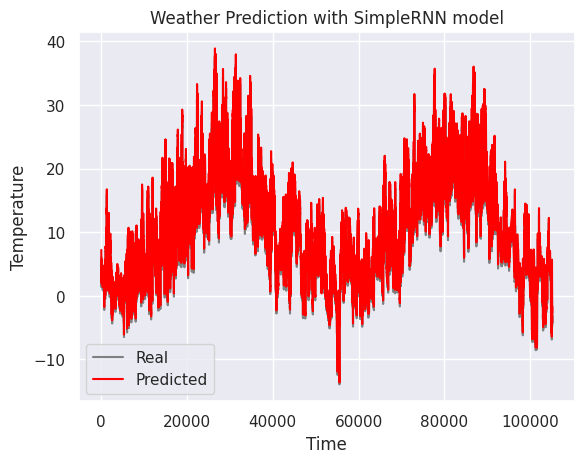

The root mean squared error is 0.83.


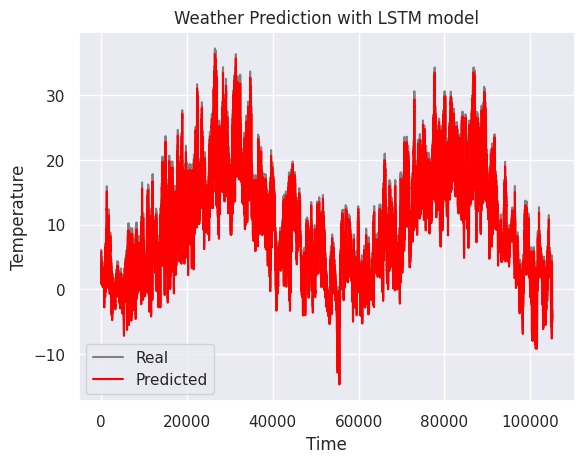

The root mean squared error is 0.75.


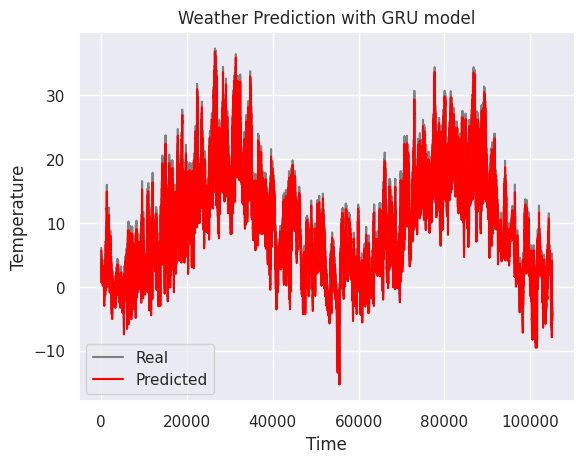

The root mean squared error is 0.95.


In [21]:
plot_predictions(SimpleRNN_y_test2,SimpleRNN_y_pred2,"SimpleRNN")
# # Evaluating our model
return_rmse(SimpleRNN_y_test2,SimpleRNN_y_pred2)


plot_predictions(lstm1_y_test2,lstm1_y_pred2,"LSTM")
# # Evaluating our model
return_rmse(lstm1_y_test2,lstm1_y_pred2)


plot_predictions(GRU1_y_test2,GRU1_y_pred2,"GRU")
# # Evaluating our model
return_rmse(GRU1_y_test2,GRU1_y_pred2)

In [22]:
print("Optimized Simple RNN ")
return1=return_rmse(SimpleRNN_y_test2,SimpleRNN_y_pred2)
print("Optimized LSTM")
return2=return_rmse(lstm1_y_test2,lstm1_y_pred2)
print("Optimized GRU")
return3=return_rmse(GRU1_y_test2,GRU1_y_pred2)

Optimized Simple RNN 
The root mean squared error is 0.83.
Optimized LSTM
The root mean squared error is 0.75.
Optimized GRU
The root mean squared error is 0.95.


#**Conclusion**
### Here we can see that the **Optimized GRU** is the best model approach as it has the **lowest** root mean error.
#### Other observation found are that early stopping improves the model as it can reduce the chance of learning rate drop. in the Simple RNN Model by **Epoch 8** max learning was achieved whilst in LSTM Model at **Epoch 10** max learning was achieved but when in GRU Model Max learning **was capped only by the computation power**.
##### Other Notes : During Selection of the data to be used horizon and history window were significantly decreased to allow for computation in which case if it wasn't maximum RAM Usage would occur during the **custom_multi_variable()** Function call for test/train selection.
